# **LSTM Exercise**

## Import libraries

In [180]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## load the dataset
### Dataset path : 5- Time series forecasting/2-2- Time Series Forecasting (LSTM and GRU)
/ LAB/Dataset/traffic.csv


In [181]:
df = pd.read_csv('traffic.csv', index_col='DateTime', parse_dates=True)
df.head()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48120 entries, 2015-11-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Junction  48120 non-null  int64
 1   Vehicles  48120 non-null  int64
 2   ID        48120 non-null  int64
dtypes: int64(3)
memory usage: 1.5 MB


In [183]:
df = df.drop('ID', axis=1)

## Normalize the dataset

In [184]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['Vehicles']] = scaler.fit_transform(df[['Vehicles']])
df[['Junction']] = scaler.fit_transform(df[['Junction']])

## split into train and test sets

In [185]:
# Split the data into train and test sets (80/20 split)
train_size = int(len(df) * 0.80)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [186]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset.iloc[i:(i + look_back)].values
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back, 1])  # Predicting 'Vehicles'
    return np.array(dataX), np.array(dataY)

In [187]:
# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


In [189]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

## Fit the LSTM

In [190]:
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=32,validation_data=(testX,testY),verbose=2,shuffle=False)

Epoch 1/20


c:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1203/1203 - 14s - 11ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2/20
1203/1203 - 10s - 8ms/step - loss: 7.5404e-04 - val_loss: 0.0010
Epoch 3/20
1203/1203 - 9s - 7ms/step - loss: 7.0940e-04 - val_loss: 0.0010
Epoch 4/20
1203/1203 - 9s - 8ms/step - loss: 6.8511e-04 - val_loss: 9.7899e-04
Epoch 5/20
1203/1203 - 10s - 8ms/step - loss: 6.6647e-04 - val_loss: 9.5729e-04
Epoch 6/20
1203/1203 - 10s - 8ms/step - loss: 6.5859e-04 - val_loss: 9.4720e-04
Epoch 7/20
1203/1203 - 10s - 8ms/step - loss: 6.5349e-04 - val_loss: 9.3662e-04
Epoch 8/20
1203/1203 - 10s - 8ms/step - loss: 6.4777e-04 - val_loss: 9.2632e-04
Epoch 9/20
1203/1203 - 9s - 7ms/step - loss: 6.3706e-04 - val_loss: 9.0972e-04
Epoch 10/20
1203/1203 - 10s - 9ms/step - loss: 6.1952e-04 - val_loss: 9.0116e-04
Epoch 11/20
1203/1203 - 10s - 8ms/step - loss: 6.0121e-04 - val_loss: 9.0405e-04
Epoch 12/20
1203/1203 - 9s - 7ms/step - loss: 5.9109e-04 - val_loss: 9.0229e-04
Epoch 13/20
1203/1203 - 9s - 8ms/step - loss: 5.8444e-04 - val_loss

## Make preductuion and evaluatuin matrix.

In [191]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY_actual, trainPredict))
testScore = np.sqrt(mean_squared_error(testY_actual, testPredict))
print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')

1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Train Score: 0.09 RMSE
Test Score: 0.09 RMSE


## Visualize the result

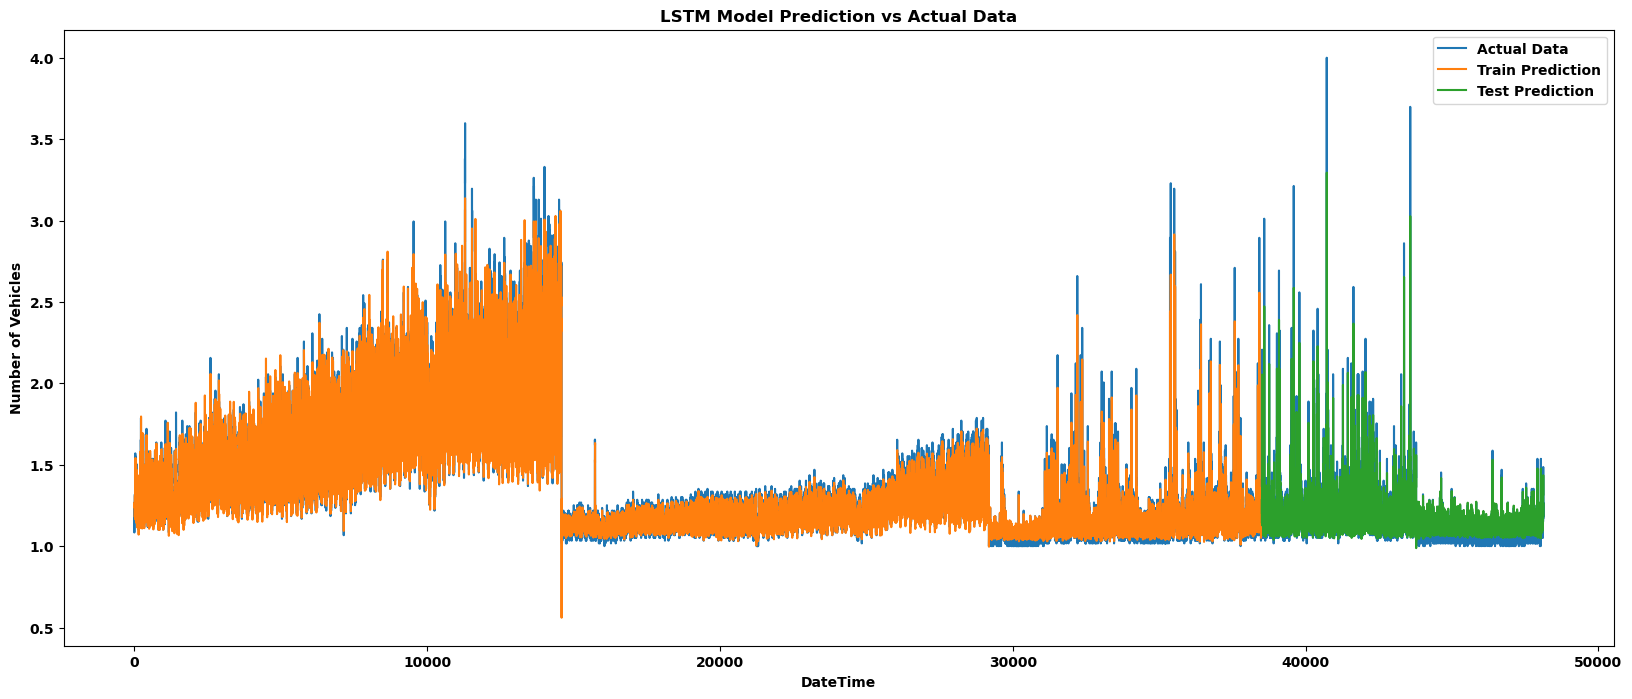

In [192]:
#Shift train predictions for plotting
trainPredictPlot = np.empty_like(df[['Vehicles']])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

#Shift test predictions for plotting
testPredictPlot = np.empty_like(df[['Vehicles']])
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2):len(trainPredict) + (look_back * 2) + len(testPredict), :] = testPredict

#Plot baseline and predictions
plt.figure(figsize=(20, 8))
plt.plot(scaler.inverse_transform(df[['Vehicles']]), label='Actual Data')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.title('LSTM Model Prediction vs Actual Data')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

# **Well done** :)